In [1]:
import json

files = []
labels = []
persons = ["Ashima Gupta", "Achinth Venkat", "Oishe Farhan", "Liu Edward"]
with open('../datasets/raw/users.json') as jsonfile:
    metadata = json.load(jsonfile)
    for person in persons:
        #print(person)
        for session in metadata[person]['sessions']:
            activity = metadata[person]['sessions'][session]['activity']
            #print(activity, end=': ')
            #print(session)
            files.append(session)
            labels.append(activity)
        #print()
print(files)
print(labels)

['1552683620495_recording.csv', '1552684135826_recording.csv', '1552684518897_recording.csv', '1552684885683_recording.csv', '1552685274491_recording.csv', '1552686579599_recording.csv', '1552687068355_recording.csv', '1552687461872_recording.csv', '1552687730763_recording.csv', '1552688006554_recording.csv', '1552684886225_recording.csv', '1552685478381_recording.csv', '1552685952146_recording.csv', '1552686877018_recording.csv', '1552687454762_recording.csv', '1552687746756_recording.csv', '1552882289936_recording.csv', '1550862070278_recording.csv', '1551117337203_recording.csv', '1551117646871_recording.csv', '1551118061985_recording.csv', '1551118320943_recording.csv', '1551249571278_recording.csv', '1553039903059_recording.csv', '1553040206684_recording.csv', '1553040672641_recording.csv', '1553041018556_recording.csv', '1553041309127_recording.csv', '1553041571909_recording.csv', '1553041964221_recording.csv', '1553042270815_recording.csv', '1553042628553_recording.csv', '155268

In [2]:
import pandas as pd
import numpy as np
from scipy import signal
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab

path = '../datasets/raw/'
fs = 256.0
def loadData(filepath, fs):
    print("Loading EEG data: "+filepath, end='...')
    try:
        with open(filepath) as file:
            pass
    except IOError:
        print("EEG data file was not found")
        exit()
    
    skip = 1
    cols = (0, 1, 2, 3, 4)
    raw_df = pd.read_csv(filepath)
    raw_df = raw_df.loc[:, ['time', 'TP9', 'AF7', 'AF8', 'TP10']]
    raw_df = raw_df.fillna(method='pad')
    raw_df = raw_df.fillna(method='bfill')
    raw_data = raw_df.values
    t_sec = np.arange(len(raw_data)) / fs
    
    print(" Complete")
    # Time, TP9, AF7, AF8, TP10
    return np.array([t_sec, raw_data[:,1], raw_data[:,2], raw_data[:,3], raw_data[:,4]])
data_collection = loadData(path+files[1], fs)
plt.plot(data_collection[0], data_collection[1])
plt.show()

Loading EEG data: ../datasets/raw/1552684135826_recording.csv... Complete


<Figure size 640x480 with 1 Axes>

Trimming EEG data to be between indices 1280 and 71702: ... Complete
(5, 70422)


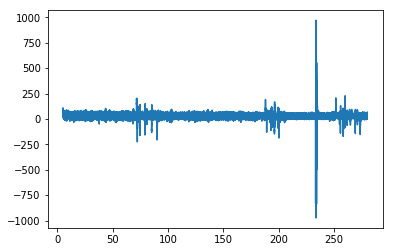

In [3]:
def trimData(dataset, fs, front, back):
    """
        Trim off begin --> front
        Trim off back --> end
    """
    
    trim_front = int(front * fs)
    trim_back = int(back * fs) * -1
    if trim_back == 0:
        trim_back = dataset.shape[1]
    
    print("Trimming EEG data to be between indices {} and {}: ".format(trim_front, dataset.shape[1]+trim_back), end='...')
    dataset = dataset[:, trim_front:trim_back]
    print(" Complete")
    return dataset
data_collection = trimData(data_collection, fs, 5, 5)
print(data_collection.shape)
plt.plot(data_collection[0], data_collection[1])
plt.show()

Bandpassing EEG data to be between 1 Hz and 45 Hz: ... Complete


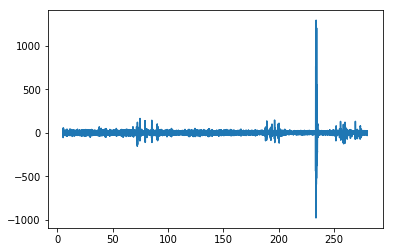

In [4]:
def bandpass(dataset, fs, cutoffs, order=5):
    bpFs = np.array(cutoffs)
    
    filtered = []
    filtered.append(dataset[0]) # time
    
    dataiter = iter(dataset)
    next(dataiter)
    
    print("Bandpassing EEG data to be between {} Hz and {} Hz: ".format(cutoffs[0], cutoffs[1]), end='...')
    for data in dataiter:
        b, a = signal.butter(order, bpFs/(fs/2.0), 'bandpass')
        channel = signal.lfilter(b, a, data)
        filtered.append(channel)
    print(" Complete")
    return np.array(filtered)
data_collection = bandpass(data_collection, fs, [1, 45])
plt.plot(data_collection[0], data_collection[1])
plt.show()

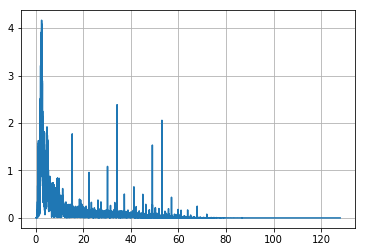

In [7]:
from scipy.fftpack import fft
# Number of sample points
N = len(data_collection[0])
# sample spacing
fs = 256.0
T = 1.0 / fs

channel = 1
x = data_collection[0]
y = data_collection[channel]
yf = fft(y)
xf = np.linspace(0.0, 1.0/(2.0*T), N//2)
import matplotlib.pyplot as plt
plt.plot(xf, 2.0/N * np.abs(yf[0:N//2]))
plt.grid()
plt.show()

In [8]:
def crunchSpecgram(dataset, fs, NFFT, overlap):
    PSD_per_hz_lst = []
    PSD_per_bin_lst = []
    freq_lst = []
    time_lst = []
    
    dataiter = iter(dataset)
    next(dataiter)
    
    print("Crunching EEG data into Spectro data: ", end='...')
    for data in dataiter:
        PSD_per_hz, freq, time = mlab.specgram(data, NFFT=NFFT, window=mlab.window_hanning, Fs=fs, noverlap=overlap)
        PSD_per_bin = PSD_per_hz * fs / float(NFFT)
        
        PSD_per_hz_lst.append(PSD_per_hz)
        PSD_per_bin_lst.append(PSD_per_bin)
        freq_lst.append(freq)
        time_lst.append(time)
    print(" Complete")
    return np.array(PSD_per_bin_lst), np.array(PSD_per_hz_lst), np.array(freq_lst), np.array(time_lst)
PSD_bin, PSD_hz, PSD_freq, PSD_time = crunchSpecgram(data_collection, fs, 512, 384)
print("bin: ", end='')
print(PSD_bin.shape)
print("hz: ", end='')
print(PSD_hz.shape)
print("freq: ", end='')
print(PSD_freq.shape)
print("time: ", end='')
print(PSD_time.shape)

Crunching EEG data into Spectro data: ... Complete
bin: (4, 257, 547)
hz: (4, 257, 547)
freq: (4, 257)
time: (4, 547)


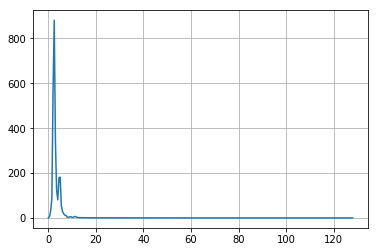

In [13]:
import matplotlib.pyplot as plt
channel = 1
plt.plot(PSD_freq[channel], np.mean(PSD_hz[channel], 1))
plt.grid()
plt.show()